In [1]:
import uproot
import numpy as np
import awkward as ak

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
plt.style.use(hep.style.ROOT)
import os,sys

from collections import OrderedDict

In [2]:
def getData(fname="", procName="Truth"):
    dq_dict = uproot.open(fname)["Truth"]
    dq_events = ak.zip({"Electrons":ak.zip({
                                            "ge": dq_dict["ge"].array(),
                                            "gvx": dq_dict["gvx"].array(),
                                            "gvy": dq_dict["gvy"].array(),
                                            "gvz": dq_dict["gvz"].array(),
                                            "gpt": dq_dict["gpt"].array(),

                                        }),
                        "Showers":ak.zip({
                                        "nshowers": dq_dict["n_showers"].array(),
                                        "sedep_ecal": dq_dict["sedep_ecal"].array(),
                                        "sx": dq_dict["sx_ecal"].array(),
                                        "sy": dq_dict["sy_ecal"].array(),
                                        "sz": dq_dict["sz_ecal"].array(),
                                        }),
                       }, depth_limit=1)
    return dq_events

In [3]:
def studyAcc(ifile,title,acceptances,mass):
    dq_events = getData(ifile,"Truth")
    # choosing the nevts for denominator (because all files have 10000 evts)
    den = len(dq_events)
    
    # choosing 500 evts for denominator
    den500 = False
    if den500:
        dq_events = dq_events[:500]
        den = 500
        
    dq_showers = dq_events["Showers"]
    dq_electrons = dq_events["Electrons"]
        
    dq_sh_z = ak.fill_none(ak.pad_none(dq_showers.sz, 2, axis=1),0)
    dq_sh_e = ak.fill_none(ak.pad_none(dq_showers.sedep_ecal, 2, axis=1),-1)
    dq_e_ge = ak.fill_none(ak.pad_none(dq_electrons.ge, 2, axis=1),-1)
    
    shower_zero_mask = ak.any(dq_sh_e==0,axis=1)
    shower_zero_index = np.where(shower_zero_mask)
    
    eshower_mask = ak.all(dq_sh_e > 0.1*dq_e_ge,axis=1)
    eshower_index = np.where(eshower_mask)
    
    masks = {
        'shower_zero':shower_zero_index,
        'eshower':eshower_index
    }
    
    dq_evts = dq_events[ak.all(dq_e_ge>-1,axis=1)]

    # we can print the mass, the number of events with gen e-, the number of events in the sample, and the denominator
    print(mass,len(dq_evts),len(dq_events),den)
    for maskstr,m in masks.items():
        if maskstr in acceptances:
            acceptances[maskstr].append(len(m[0])/den)
        else:
            acceptances[maskstr] = [len(m[0])/den]
        #print(maskstr+':', len(m[0])/den)
    return acceptances

In [ ]:
studyAcc('data/simana_electrons_Mar22/Brem_0.470915_z500_600_eps_-6.root',r'Brem m=0.47 GeV $v_z$:5-6 m',{},0.01)

In [4]:
masses = {}
masses['Brem'] = ["0.011603","0.015117","0.025659","0.033428","0.043551",
                  "0.056739","0.073920",
                  "0.096304","0.125467","0.163460","0.212958","0.361459","0.470915","0.613515","0.799296",
                  "1.356670",
                  "1.767490","2.302710"
                 ]
masses['Eta'] = ["0.010502","0.012922","0.015900","0.019564","0.024072","0.029619","0.036445","0.044843","0.055176",
                 "0.067891","0.083535","0.102784","0.126469","0.155612","0.191470","0.235592","0.289880",
                 "0.540000"]
acceptances = {}
for proc in ["Brem","Eta"]:
    acceptances[proc] = {}
    print(proc)
    for mass in masses[proc]:
        ifile = "data/simana_electrons_Mar22/%s_%s_z500_600_eps_-6.root"%(proc,mass)
        studyAcc(ifile,'',acceptances[proc],mass)

Brem
0.011603 10000 10000 10000
0.015117 10000 10000 10000
0.025659 10000 10000 10000
0.033428 10000 10000 10000
0.043551 10000 10000 10000
0.056739 10000 10000 10000
0.073920 10000 10000 10000
0.096304 10000 10000 10000
0.125467 10000 10000 10000
0.163460 10000 10000 10000
0.212958 10000 10000 10000
0.361459 10000 10000 10000
0.470915 10000 10000 10000
0.613515 10000 10000 10000
0.799296 10000 10000 10000
1.356670 10000 10000 10000
1.767490 10000 10000 10000
2.302710 10000 10000 10000
Eta
0.010502 10000 10000 10000
0.012922 10000 10000 10000
0.015900 10000 10000 10000
0.019564 10000 10000 10000
0.024072 10000 10000 10000
0.029619 10000 10000 10000
0.036445 10000 10000 10000
0.044843 10000 10000 10000
0.055176 10000 10000 10000
0.067891 10000 10000 10000
0.083535 10000 10000 10000
0.102784 10000 10000 10000
0.126469 10000 10000 10000
0.155612 10000 10000 10000
0.191470 10000 10000 10000
0.235592 10000 10000 10000
0.289880 10000 10000 10000
0.540000 10000 10000 10000


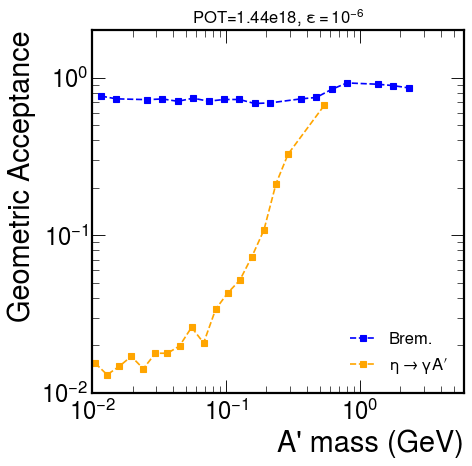

In [5]:
def plotAcceptance(masses,acceptances):
    fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=80)
    labels = {'Brem': 'Brem.',
              'Eta': r'$\eta \rightarrow \gamma A\prime$',
             }
    colors = {'Brem': ['blue'],
              'Eta': ['orange'],
              }
    for proc,acc in acceptances.items():
        masslist = [float(i) for i in masses[proc]]
        plt.plot(masslist,acc['eshower'], color=colors[proc][0], label=labels[proc], marker='s', linestyle='dashed')
        #r'$E_{dep}^{EMCAL}>0.1 E_{e^-}$'
        #plt.plot(masses,acc['shower_zero'],color='blue', label=r'Shower edep==0') #(same as w. ecal hits)')
        #plt.plot(masses,acc['h4y_hits'],color='green', label=r'St4 hits  (out of acceptance)')
    ax.set_xlabel("A' mass (GeV)")
    ax.set_ylabel(r"Geometric Acceptance")
    ax.set_xlim(0.01,6) 
    ax.set_ylim(0.01,2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(prop={'size': 15})
    ax.set_title('POT=1.44e18, $\epsilon=10^{-6}$', fontsize=15)
    plt.show()
    #plt.savefig('acceptance_%s%s.png'%(mech,tag))
    
plotAcceptance(masses,acceptances)

Now looking at the information of the original displaced acceptance samples. 
We have output files check this link: https://github.com/cmantill/DarkQuest/tree/master/lhe/outputs, that calculate the acceptance of displacing events from 5 to 6 m, for different masses and couplings. 
They do that by randomly sampling the original events ( a given number of times N), and then checking how many events have a displacement within that range (N_acc). Then we compute a "displacement acceptance" by taking the ration of these 2 numbers.

Below we open the output files that save these two numbers, compute the acceptance, and multiply by x-section: i.e. the rates given in the yields files, the Branching ratio to electrons, and the luminosity: number of protons on target: POT.

In [6]:
class event:
    def __init__(self,values):
        self._acpE = int(values[0])
        self._nEv = int(values[1])
        self._mass = float(values[2])
        self._eps = float(values[3])
        self._minvz = float(values[4])
        self._maxvz = float(values[5])
        self._mech = str(values[6])
        
    def getRatio(self):
        return(self._acpE/self._nEv)
    
    def getEps(self):
        return self._eps
    
    def getMass(self):
        return self._mass
    
    def getMech(self):
        return self._mech
    
    def __repr__(self):
        return str([self._acpE,self._nEv,self._mass,self._eps,self._minvz,self._maxvz,self._mech])
    
def parseFile(minVz,maxVz,lep="muons",mech="Brem",file10k=True):
    #line format: n_accepted total_events mass eps min_vz max_vz Brem/Eta 
    # these try 10k sampling at most..
    if file10k:
        fileName = "/Users/cmantill/DQ/DarkQuest/lhe/outputs/output_%s_%i_%i_%s_Apr22_10000evts.txt"%(lep,minVz,maxVz,mech)
    else:
        # these try 10 events minimum or 10k*1e4 sampling at most..
        fileName = "/Users/cmantill/DQ/DarkQuest/lhe/outputs/output_%s_%i_%i_%s_Apr22_up10evts.txt"%(lep,minVz,maxVz,mech)
    file = open(fileName)
    prevLine = ""
    spStr = ""
    eventsList = []
    for l in file.readlines():
        spStr = l.split()
        newEvent = event(spStr)
        if newEvent.getMech()==mech:
            eventsList.append(newEvent)
    return eventsList

In [7]:
# rates: xs *BR
# assume that BR e- ~= BR muons for now
# unless Asher can give us similar files for e-
def getRate(lep="muons",mech="Brem"):
    rates = OrderedDict() 
    ifile = open("/Users/cmantill/DQ/DarkQuest/lhe/data/AprimeToMuonsRate_%s.txt"%mech)
    for l in ifile:
        temp = l.split()
        if 'GeV' in l: continue
        rates['%.3f'%float(temp[0])] = float(temp[1])
    return rates

def getRatefromAsher(epsilon,POT,lep="muons",mech="Brem"):
    bfs = {}
    if lep=='muons':
        iBFfile = "/Users/cmantill/DQ/DarkQuest/lhe/data/BFtoMuons.txt"
    else:
        iBFfile = "/Users/cmantill/DQ/DarkQuest/lhe/data/BFtoElectrons.txt"
    iBR = open(iBFfile)
    #Log[10,mAp/GeV]	Log[10,BF]
    for l in iBR:
        temp = l.split()
        if '#' in l or len(temp)==0: continue
        mass = pow(10,float(temp[0]))
        bfs['%.3f'%mass] = pow(10,float(temp[1]))

    rates = OrderedDict() 
    ifileYield = open("/Users/cmantill/DQ/DarkQuest/lhe/data/%sYield.txt"%mech)
    #epsilon = 10^-6, POT = 1.44*10^18, rescale yield as NAp = column2*(epsilon/10^-6)^2 (POT/1.44*10^18)
    #Log[10,mAp/GeV]	Log[10,NAp]
    for l in ifileYield:
        temp = l.split()
        if '#' in l or len(temp)==0: continue
        mass = pow(10,float(temp[0]))
        column2 = pow(10,float(temp[1]))
        NAp = column2*(POT/1.44e18)*(epsilon/10**(-6))**2
        if '%.3f'%mass in bfs:
            BF = bfs['%.3f'%mass]
        else:
            print('No BF!')
            BF = 1
        rates['%.3f'%mass] = NAp*BF
    return rates

# this function interpolates between existent rates
def addrates(masses,rates):
    im = 0
    lrates = list(rates.values())
    new_rates = {}
    for m in masses:
        mass = '%.3f'%m
        if mass in list(rates.keys()):
            im = im + 1
            new_rates[mass] = rates[mass]
        else:
            new_rates[mass] = lrates[im-1]
    return new_rates

In [8]:
def yields(minVz,maxVz,lep="muons",mech="Brem",file10k=True):
    events = parseFile(minVz,maxVz,lep,mech,file10k)
    
    # protons on target
    #POT = 10**18 
    POT = 1.44e18
    
    yields = {}
    masses = []
    epsilons = []
    couplings = {}
        
    for ev in events:
        if ev.getMass() not in masses:
            masses.append(ev.getMass())
        if ev.getEps() not in epsilons:
            epsilons.append(ev.getEps())
        if ev.getEps() in couplings:
            couplings[ev.getEps()].append(ev)
        else:
            couplings[ev.getEps()]=[ev]

    cross = []
    i=0
    rates_per_eps = {}
    ratios_per_eps = {}
    for eps in epsilons:
        old_rates = getRate(lep,mech)
        rates = getRatefromAsher(eps,POT,lep,mech)
        new_rates = addrates(masses,rates)
        rates_per_eps['%.2e'%eps] = rates
        ratios_per_eps['%.2e'%eps] = {}
        cross.append([])
        for m in masses:
            for ev in events:
                if ev.getMass() == m and ev.getEps() == eps:
                    cross[i].append(ev.getRatio()*new_rates['%.3f'%m]) #*POT*eps**2) # this is not needed anymore since its accounted for in the new_rates
                    ratios_per_eps['%.2e'%eps]['%.3f'%m] = ev.getRatio()
        i+=1
    
    # now plot
    fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=80)
    CS = ax.contour(masses, epsilons, cross,levels=1000,cmap = "viridis")
    ax.set_xlabel("mass (GeV)")
    ax.set_ylabel(r"$\epsilon$")
    ax.set_title(r'Acceptance*POT*$\epsilon^{2}$*XS*BR %s %i %i'%(mech,minVz,maxVz), fontsize=15)
    ax.set_yscale('log')
    if lep=='muons':
        if 'Brem' in mech:
            #ax.set_xlim(.25,3.05)
            ax.set_xlim(.25,5)
            ax.set_xscale('log')
        else:
            ax.set_xlim(.25,5)
            #ax.set_xlim(.25,.55)
    if lep=='electrons':
        ax.set_ylim(1e-8,1e-2)
        if 'Brem' in mech:
            #ax.set_xlim(.01,3.05)
            ax.set_xlim(.01,5)
            ax.set_xscale('log')
        else:
            #ax.set_xlim(.01,1.5) 
            ax.set_xscale('log')
            ax.set_xlim(.01,5)
    plt.colorbar(CS)
    plt.show()
    #plt.savefig("yield_%s_%s.png"%(lep,mech))
    plt.clf()
    
    # now plot 10 ev contour
    fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=80)
    CS = ax.contour(masses, epsilons, cross,levels=[10],cmap = "viridis")
    ax.set_xlabel("mass (GeV)")
    ax.set_ylabel(r"$\epsilon$")
    ax.set_title(r'Acceptance*POT*$\epsilon^{2}$*XS*BR %s %i %i 10ev'%(mech,minVz,maxVz), fontsize=15)
    ax.set_yscale('log')
    if lep=='muons':
        if 'Brem' in mech:
            ax.set_xlim(.25,5)
            ax.set_xscale('log')
        else:
            ax.set_xlim(.25,5)
    if lep=='electrons':
        ax.set_ylim(1e-8,1e-2)
        if 'Brem' in mech:
            ax.set_xlim(.01,5)
            ax.set_xscale('log')
        else:
            ax.set_xlim(.01,5) 
            ax.set_xscale('log')
    plt.show()
    #plt.savefig("yield_%s_%s_10ev.png"%(lep,mech))
    plt.clf()
    
    fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=80)
    CS = ax.contour(masses, epsilons, cross,levels=[10000],cmap = "viridis")
    ax.set_xlabel("mass (GeV)")
    ax.set_ylabel(r"$\epsilon$")
    ax.set_title(r'Acceptance*POT*$\epsilon^{2}$*XS*BR %s %i %i 10$^3$ev'%(mech,minVz,maxVz), fontsize=15)
    ax.set_yscale('log')
    if lep=='muons':
        if 'Brem' in mech:
            ax.set_xlim(.25,5)
            ax.set_xscale('log')
        else:
            ax.set_xlim(.25,5)
    if lep=='electrons':
        ax.set_ylim(1e-8,1e-2)
        if 'Brem' in mech:
            ax.set_xlim(.01,5)
            ax.set_xscale('log')
        else:
            ax.set_xlim(.01,5) 
            ax.set_xscale('log')
    plt.show()
    #plt.savefig("yield_%s_%s_10000ev.png"%(lep,mech))
    plt.clf()
    
    # now plot rates
    fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=80)
    masses = [float(i) for i in rates_per_eps['%.2e'%(1e-06)].keys()]
    naps = list(rates_per_eps['%.2e'%(1e-06)].values())
    plt.plot(masses,naps,color='blue')
    ax.set_xlabel("mass (GeV)")
    ax.set_ylabel(r"$N_A^{'}$")
    ax.set_xlim(.01,1.5) 
    ax.set_ylim(1,1e7)
    ax.set_xscale('log')
    ax.set_title(r'$E_{beam}=$120 GeV,POT=1.44e18,$\epsilon=10^{-6}$ %s'%(mech), fontsize=15)
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.show()
    #plt.savefig("nap_eps1em6_%s_%s.png"%(lep,mech))
    plt.clf()
    
    # now plot acceptance only
    fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=80)
    masses = [float(i) for i in ratios_per_eps['%.2e'%(1e-06)].keys()]
    naps = list(ratios_per_eps['%.2e'%(1e-06)].values())
    plt.plot(masses,naps,color='green')
    ax.set_xlabel("mass (GeV)")
    ax.set_ylabel(r"Acceptance")
    ax.set_title("Acceptance")
    ax.set_xlim(.01,1.5) 
    ax.set_ylim(0.01,1)
    ax.set_xscale('log')
    ax.set_title(r'$E_{beam}=$120 GeV,POT=1.44e18,$\epsilon=10^{-6}$ %s'%(mech), fontsize=15)
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.show()
    #plt.savefig("accept_eps1em6_%s_%s.png"%(lep,mech))
    plt.clf()

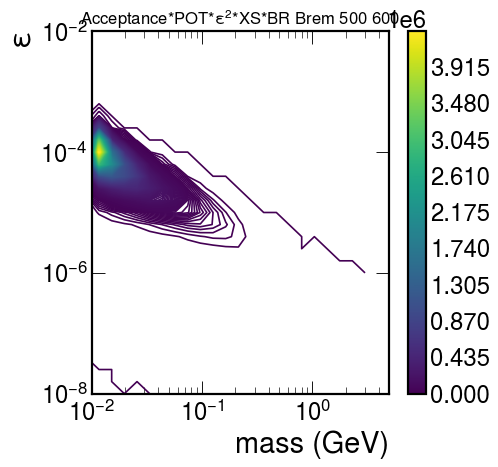

<Figure size 720x720 with 0 Axes>

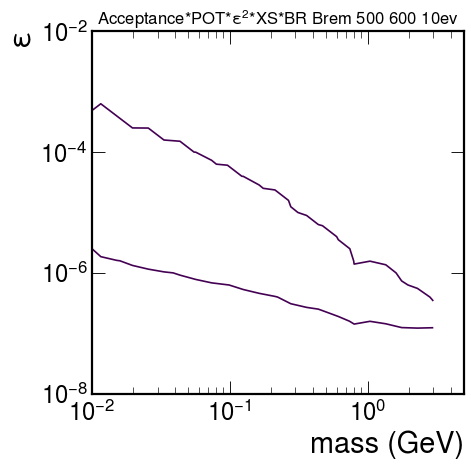

<Figure size 720x720 with 0 Axes>

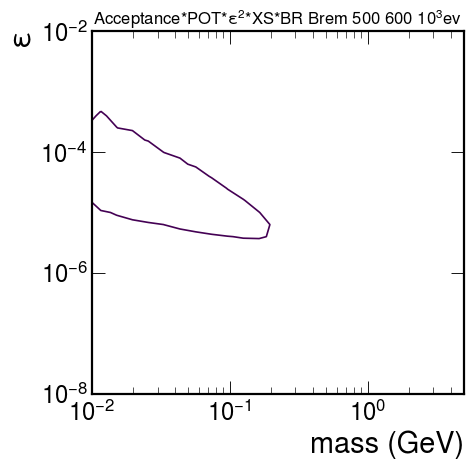

<Figure size 720x720 with 0 Axes>

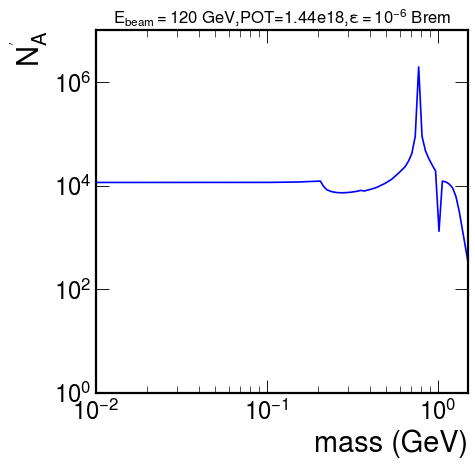

<Figure size 720x720 with 0 Axes>

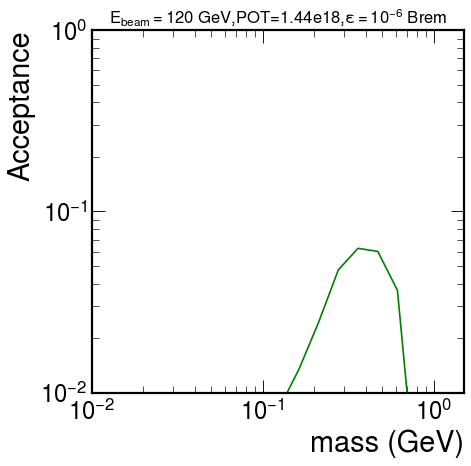

<Figure size 720x720 with 0 Axes>

In [9]:
yields(500,600,"electrons","Brem",True)

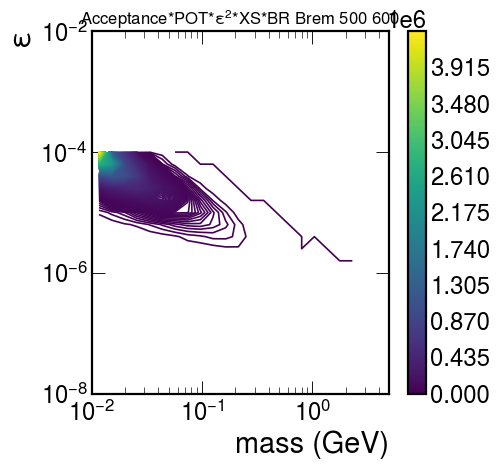

<Figure size 720x720 with 0 Axes>

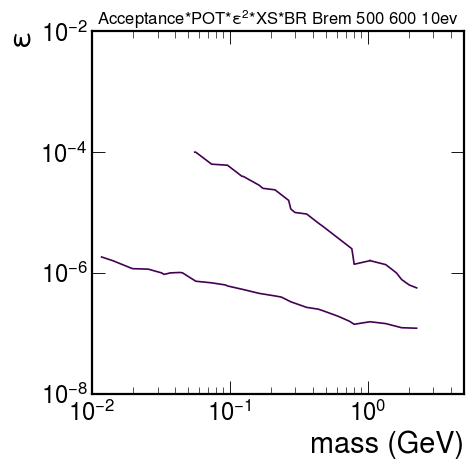

<Figure size 720x720 with 0 Axes>

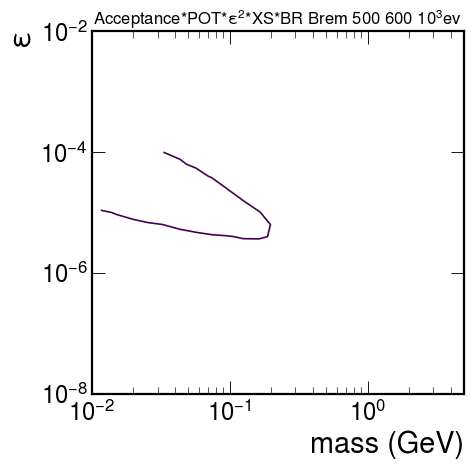

<Figure size 720x720 with 0 Axes>

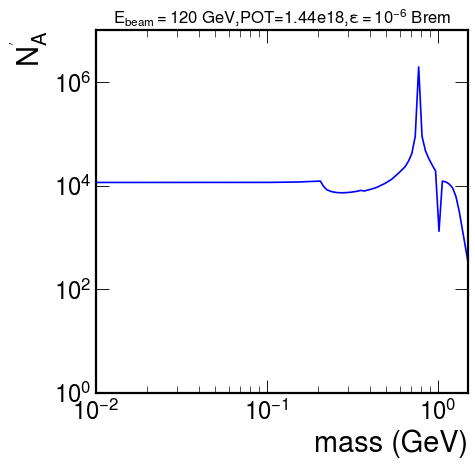

<Figure size 720x720 with 0 Axes>

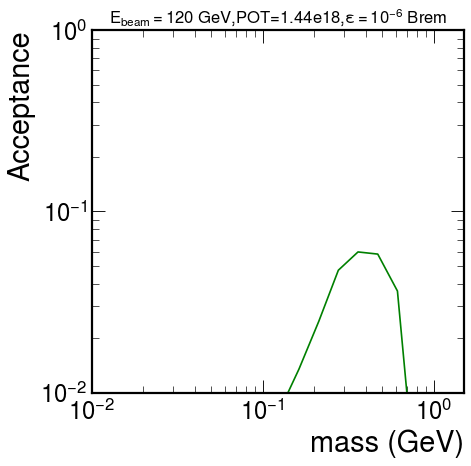

<Figure size 720x720 with 0 Axes>

In [10]:
# let's check how this looks when we sample less number of times (and require that we produce 10 events or sample at least 10e3*10e4 times)
yields(500,600,"electrons","Brem",False)

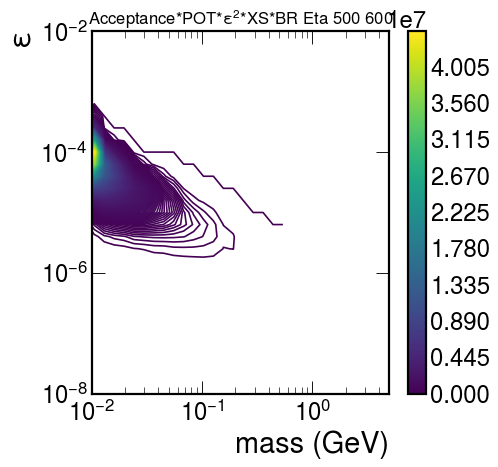

<Figure size 720x720 with 0 Axes>

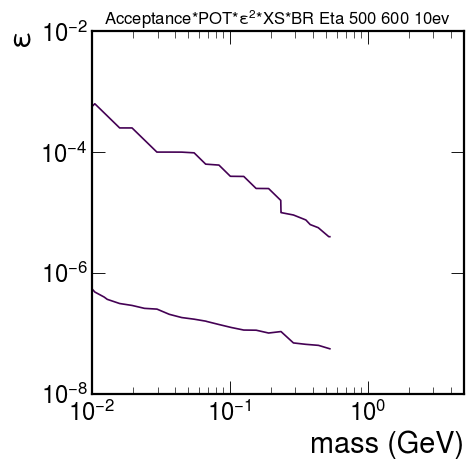

<Figure size 720x720 with 0 Axes>

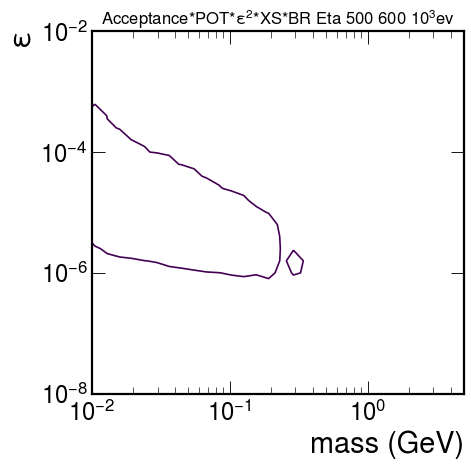

<Figure size 720x720 with 0 Axes>

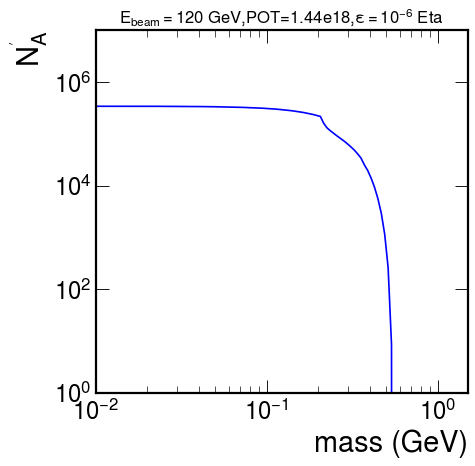

<Figure size 720x720 with 0 Axes>

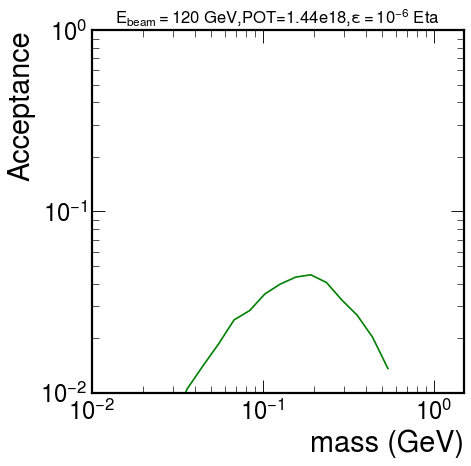

<Figure size 720x720 with 0 Axes>

In [11]:
# we can also check for ETa
yields(500,600,"electrons","Eta")

Now your task is to get similar "EMCAL acceptance" plots for different couplings and multiply this acceptance by the first plot above: i.e. displaced acceptance * emcal acceptance * POT * eps^2 * rate * Branching ratio.

Not all masses have the same couplings scanend because as you can seen from the plots above they would have no events in certain regions of phase space). You can already perform this task for a fixed coupling eps = 10^-6.